# Accelerating Dual Momentum

### Assets: 
- US Equities = SPY : S&P 500
- Foreign Equities = VSS : Vanguard FTSE All-World ex-US Small Cap ETF
- Long Term Treasuries = TLT : iShares 20+ Year Treasury Bond ETF

### Rules:
1. Calculate the 1 month, 3 month, and 6 month return for all assets. Select the ETF that has a better performance.
2. Pick highest signal score equity. If signal score > 0 go long that ETF
3. If signal score < 0 go long TLT

https://engineeredportfolio.com/2018/05/02/accelerating-dual-momentum-investing/

*Notes: Model does not have transaction costs built in

In [1]:
# Importing all the necessary packages we will use for our code
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt
import seaborn as sns
from scipy import stats
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
import yfinance as yf

# Allows entire DataFrame to be displayed when called
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
#List used for indicator generation
#EASIER IF IN ALPHABETICAL ORDER
symbols = ['SPY', 'TLT', 'VSS']

#List used for rebalance criteria 
#EASIER IF IN ALPHABETICAL ORDER
assets = ['SPY', 'TLT', 'VSS']

start_date = '2000-07-01'
end_date = '2022-07-08'
interval = '1d'

price = yf.download(symbols, start=start_date, end=end_date, interval=interval)
price = price.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
price.columns = price.columns.droplevel(0)

#Renaming symbol columns to symbol_price (mandatory)
new_cols_list = ['SPY_Price', 'TLT_Price', 'VSS_Price']
price.columns = new_cols_list

price = price.dropna()
price.head()

[*********************100%***********************]  3 of 3 completed


,SPY_Price,TLT_Price,VSS_Price
Date,,,
2009-04-06,64.790016,71.755745,36.744118
2009-04-07,63.278755,71.937798,35.899170
2009-04-08,63.960770,72.575027,36.374016
2009-04-09,66.502724,71.664757,37.568089
2009-04-13,66.518257,72.322914,38.217514


In [3]:
#Indicator and Signal 

#1 Month Return
for symbol in symbols:
    price[str(symbol) + '_ROC_1'] = (price[symbol + '_Price'].shift(1) / price[symbol + '_Price'].shift(22)) - 1

#3 Month Return
for symbol in symbols:
    price[str(symbol) + '_ROC_3'] = (price[symbol + '_Price'].shift(1) / price[symbol + '_Price'].shift(64)) - 1

#6 Month Return
for symbol in symbols:
    price[str(symbol) + '_ROC_6'] = (price[symbol + '_Price'].shift(1) / price[symbol + '_Price'].shift(127)) - 1

#Signal Score
for symbol in symbols:
    price[str(symbol) + '_Signal'] = ((price[str(symbol) + '_ROC_1']) + 
                                      (price[str(symbol) + '_ROC_3']) +
                                      (price[str(symbol) + '_ROC_6']))
    
price = price.dropna()
price.head()

,SPY_Price,TLT_Price,VSS_Price,SPY_ROC_1,TLT_ROC_1,VSS_ROC_1,SPY_ROC_3,TLT_ROC_3,VSS_ROC_3,SPY_ROC_6,TLT_ROC_6,VSS_ROC_6,SPY_Signal,TLT_Signal,VSS_Signal
Date,,,,,,,,,,,,,,,
2009-10-06,82.623856,69.973877,56.282307,0.038405,0.025492,0.055964,0.186866,0.055210,0.233770,0.257246,-0.015085,0.502470,0.482517,0.065618,0.792204
2009-10-07,82.850922,70.794647,56.575607,0.038728,0.032938,0.058437,0.204688,0.025820,0.270091,0.305712,-0.027300,0.567789,0.549129,0.031458,0.896317
2009-10-08,83.485237,70.052322,57.406548,0.032679,0.052461,0.043535,0.205670,0.050370,0.260228,0.295340,-0.024532,0.555385,0.533688,0.078299,0.859147
2009-10-09,83.994263,68.446426,57.532257,0.032660,0.042638,0.047661,0.217801,0.029852,0.289973,0.255366,-0.022500,0.528067,0.505827,0.049990,0.865701
2009-10-12,84.323135,68.553528,57.797596,0.028446,0.000305,0.040804,0.196125,0.011921,0.280740,0.262725,-0.053600,0.505390,0.487297,-0.041374,0.826933


In [4]:
#Creating a dataframe of daily returns 
ret = price[['SPY_Price', 'TLT_Price', 'VSS_Price']].pct_change()
ret.columns = assets
ret = ret.dropna()
ret.head()

,SPY,TLT,VSS
Date,,,
2009-10-07,0.002748,0.011730,0.005211
2009-10-08,0.007656,-0.010486,0.014687
2009-10-09,0.006097,-0.022924,0.002190
2009-10-12,0.003915,0.001565,0.004612
2009-10-13,-0.002043,0.005206,0.000846


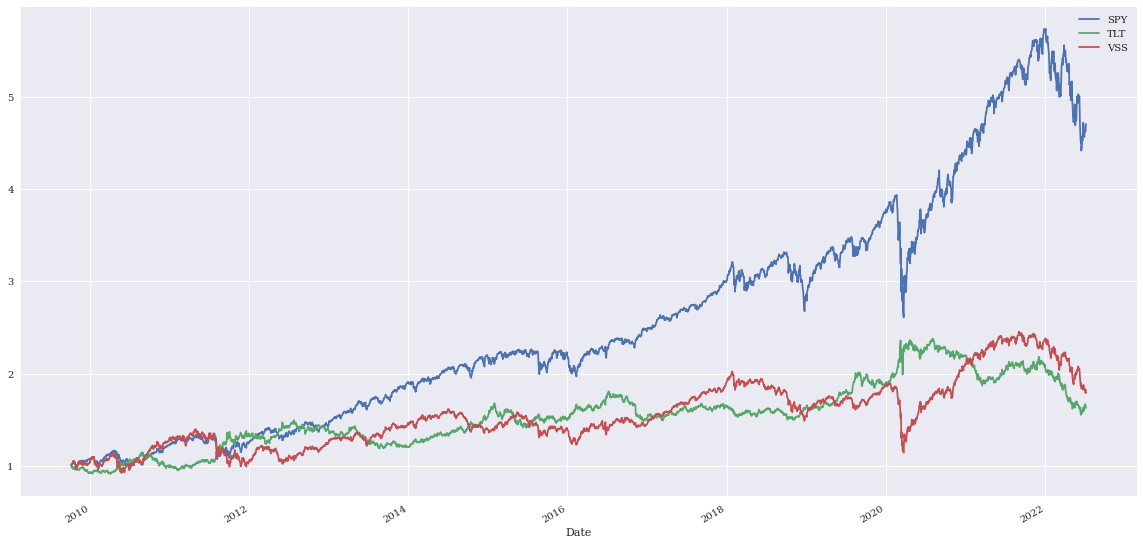

In [5]:
ret.add(1).cumprod().plot(figsize=(20,10))

In [6]:
#Getting rebalance dates 

#END OF MONTH

rebal = pd.DataFrame(index=price.index)
rebal['Rebal'] = price.index
rebal['Bool'] = np.where(rebal['Rebal'].dt.month == rebal['Rebal'].dt.month.shift(-1), False, True)
rebal = rebal[rebal.Bool == True]
rebal.head()

,Rebal,Bool
Date,,
2009-10-30,2009-10-30,True
2009-11-30,2009-11-30,True
2009-12-31,2009-12-31,True
2010-01-29,2010-01-29,True
2010-02-26,2010-02-26,True


In [7]:
def select_assets(rb_date):
    positions = []
    
    if price['SPY_Signal'][rb_date] > price['VSS_Signal'][rb_date]:
        if price['SPY_Signal'][rb_date] > 0.0:
            positions.append('SPY')
        else:
            positions.append('TLT')
    elif price['SPY_Signal'][rb_date] < price['VSS_Signal'][rb_date]:
        if price['VSS_Signal'][rb_date] > 0.0:
            positions.append('VSS')
        else:
            positions.append('TLT')
    
    print("Assets to go Long:\n", positions)
    return positions

def calc_returns(positions, rb_date, next_rb_date):
    print('Position Returns:\n', ret.loc[rb_date:next_rb_date,positions][1:].add(1).cumprod())
    return ret.loc[rb_date:next_rb_date,positions][1:].add(1).cumprod()

def rebalance(old_portfolio , weights):
    dollar_size = (weights * old_portfolio.sum())
    print('Dollar Weights:\n', dollar_size)
    return  dollar_size 

def calc_weights(positions, rb_date):
    weights = pd.Series(1.0, index=positions)
    print('Target Allocation by %:\n', weights)
    return weights

def update_portfolio_value(portfolio_value, future_values):
    return pd.concat([portfolio_value, future_values.sum(axis=1)])

def get_rebalance_dates(start_delay=0):
    t = pd.DataFrame({'date' : rebal.index[start_delay:]})
    rebal_dates = rebal.index[start_delay:]
    future_days = rebal.index[1:]
    return zip(rebal_dates, future_days)

In [8]:
rebalance_dates = get_rebalance_dates()

In [9]:
def calculate_portfolio_ret():
    #Store to daily total value of the portfolio
    portfolio_value = pd.Series()
    
    #Starting cash amount in portfolio
    current_positions = pd.Series(10000)          

    for rb, rb_next in rebalance_dates:          # rb = rebalance date
        
        print(' \n-Rebalance: ', rb)
        positions  = select_assets(rb)  
        weights       = calc_weights(positions, rb)                    
        new_positions = rebalance(current_positions, weights)        
        cum_ret       = calc_returns(positions, rb, rb_next)
        future_values = cum_ret * new_positions                 
        portfolio_value = update_portfolio_value(portfolio_value, future_values)
        current_positions = future_values.iloc[-1]               # For next round  
           
    portfolio_return = portfolio_value.pct_change().to_frame('Portfolio')
    
    #Daily portfolio returns
    return portfolio_return     

In [10]:
pr = calculate_portfolio_ret()
pr

<ipython-input-9-c67902e346f5>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  portfolio_value = pd.Series()


 
-Rebalance:  2009-10-30 00:00:00
Assets to go Long:
 ['VSS']
Target Allocation by %:
 VSS    1.0
dtype: float64
Dollar Weights:
 VSS    10000.0
dtype: float64
Position Returns:
                  VSS
Date                
2009-11-02  1.007806
2009-11-03  1.010109
2009-11-04  1.027255
2009-11-05  1.043890
2009-11-06  1.043506
2009-11-09  1.071145
2009-11-10  1.060141
2009-11-11  1.064492
2009-11-12  1.049904
2009-11-13  1.064875
2009-11-16  1.084453
2009-11-17  1.074856
2009-11-18  1.073705
2009-11-19  1.054894
2009-11-20  1.049392
2009-11-23  1.063596
2009-11-24  1.058989
2009-11-25  1.068458
2009-11-27  1.038516
2009-11-30  1.044274
 
-Rebalance:  2009-11-30 00:00:00
Assets to go Long:
 ['VSS']
Target Allocation by %:
 VSS    1.0
dtype: float64
Dollar Weights:
 VSS    10442.73672
dtype: float64
Position Returns:
                  VSS
Date                
2009-12-01  1.027080
2009-12-02  1.030021
2009-12-03  1.025242
2009-12-04  1.020096
2009-12-07  1.017523
2009-12-08  0.997795
2009-1

,Portfolio
2009-11-02,NaN
2009-11-03,0.002285
2009-11-04,0.016975
2009-11-05,0.016193
2009-11-06,-0.000367
2009-11-09,0.026486
2009-11-10,-0.010274
2009-11-11,0.004104
2009-11-12,-0.013704
2009-11-13,0.014260


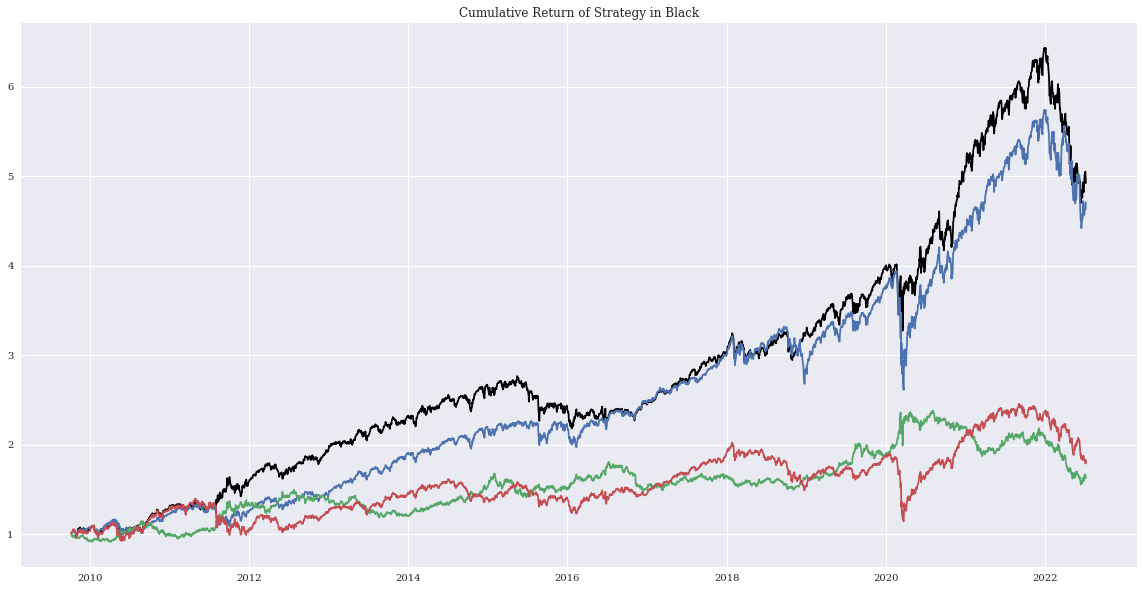

In [11]:
plt.figure(figsize=(20,10))
plt.plot(pr.add(1).cumprod(), color='black')
plt.plot(ret.add(1).cumprod())
plt.title("Cumulative Return of Strategy in Black");

In [12]:
#Performance Metrics

%matplotlib inline
import quantstats as qs

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2009-11-02  2009-11-02
End Period                 2022-07-07  2022-07-07
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          392.23%     376.17%
CAGR﹪                     13.39%      13.09%

Sharpe                     0.87        0.8
Smart Sharpe               0.86        0.78
Sortino                    1.23        1.11
Smart Sortino              1.21        1.09
Sortino/√2                 0.87        0.78
Smart Sortino/√2           0.85        0.77
Omega                      1.17        1.17

Max Drawdown               -26.95%     -33.72%
Longest DD Days            788         277
Volatility (ann.)          15.85%      17.3%
R^2                        0.17        0.17
Calmar                     0.5         0.39
Skew                       -0.36       -0.59
Kurtosis                   5.44        1

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-01-04,2022-06-14,2022-07-07,184,-26.954047,-26.020923
2,2015-05-18,2016-06-27,2017-07-14,788,-21.151525,-20.096378
3,2020-02-20,2020-03-18,2020-06-03,104,-18.496189,-16.277200
4,2011-10-04,2011-11-25,2012-01-18,106,-13.236321,-13.072243
5,2010-04-26,2010-05-26,2010-09-20,147,-12.018714,-11.575409


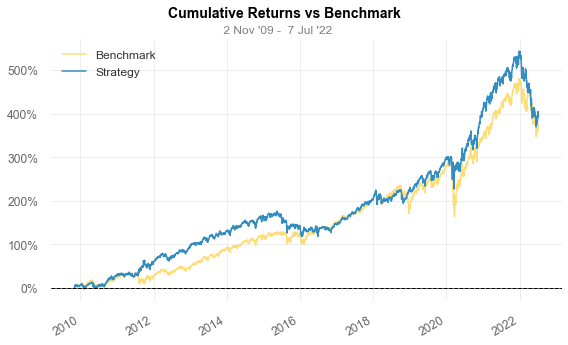

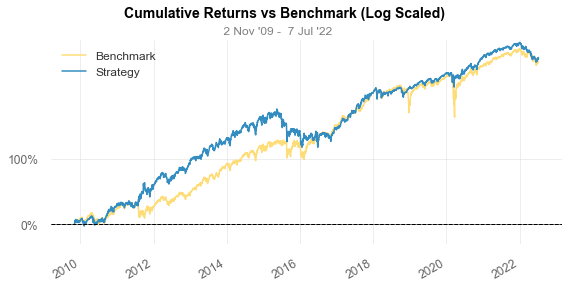

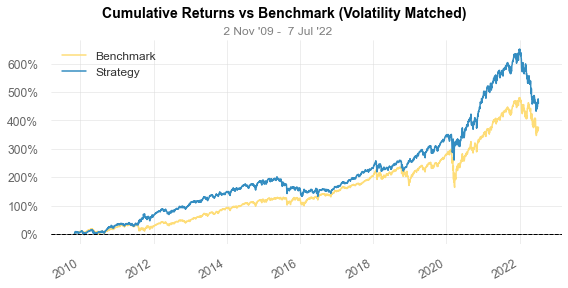

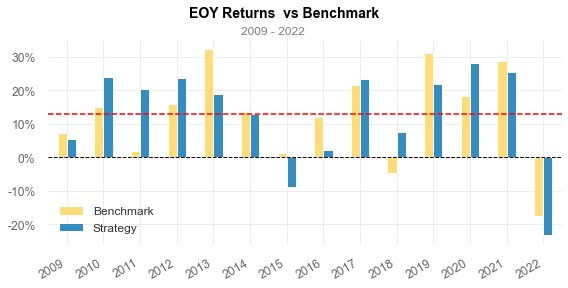

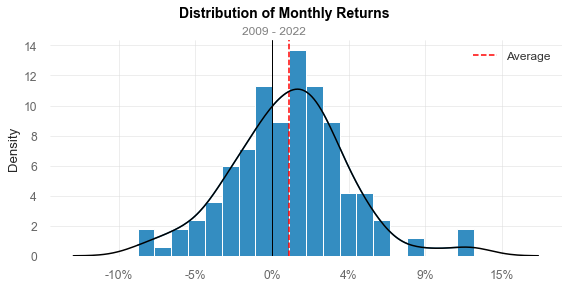

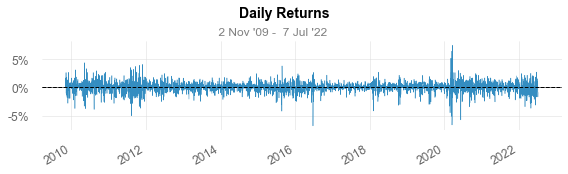

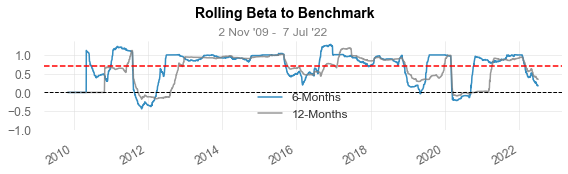

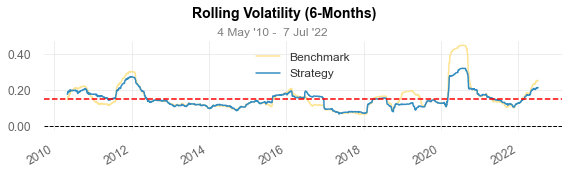

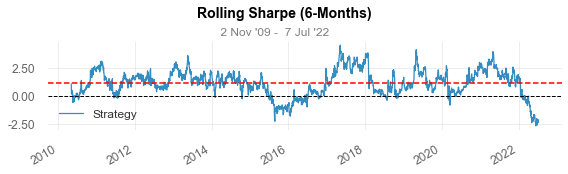

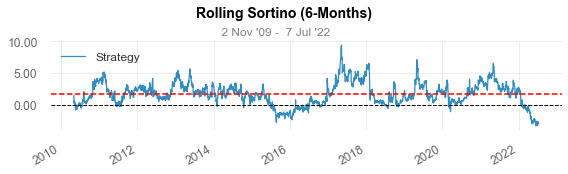

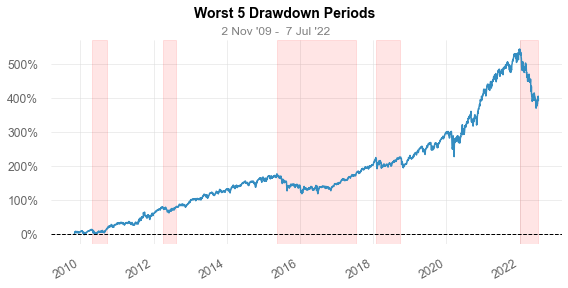

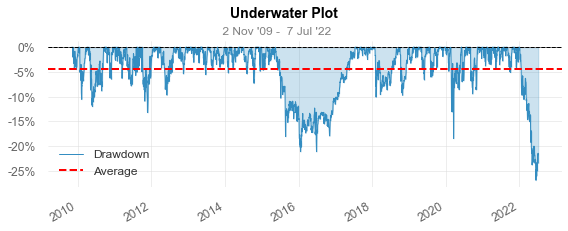

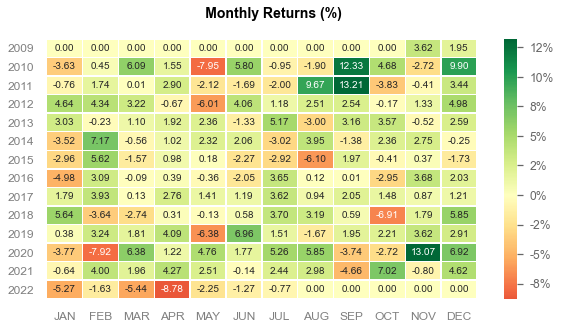

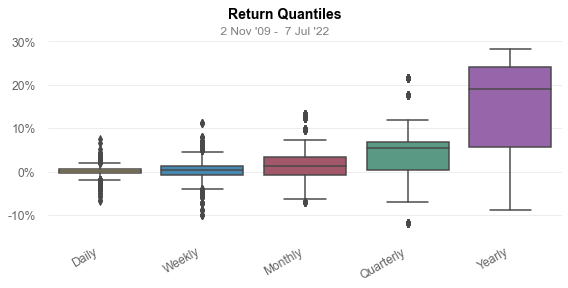

In [13]:
qs.reports.full(pr.Portfolio, "SPY")